In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
lb_make=LabelEncoder()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import copy
import time as time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

#!pip install adversarial-robustness-toolbox >/dev/null
import os,sys
sys.path.append(os.path.dirname('../adversarial-robustness-toolbox/'))
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, DeepFool, SaliencyMapMethod, CarliniL2Method, CarliniLInfMethod, CarliniL0Method
from art.classifiers import PyTorchClassifier

%matplotlib inline

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The module art.classifiers will be removed in ART 1.8.0 and replaced with art.estimators.classification


In [20]:


missing_values = ["n/a", "na", "Infinity", "NaN","nan","-","excel","?","#DIV/0!","aza"]

#df_testing = pd.read_csv("test.csv", na_values = missing_values, engine='python', skipinitialspace=True)
#df_training = pd.read_csv("train.csv", na_values = missing_values, engine='python', skipinitialspace=True)


missing_values = ["n/a", "na", "Infinity", "NaN","nan","-","excel","?","#DIV/0!","aza"]
df = pd.read_csv("Binary-X-IIoTD.csv", na_values = missing_values, engine='python', skipinitialspace=True)
df=df.fillna(df.median())
df['class3'].value_counts()

#df_training=df_training.fillna(df_training.median())
#df_testing=df_testing.fillna(df_testing.median())
#n_training = len(df_training)  # Number of rows in the original training DataFrame
#n_testing = len(df_testing)    # Number of rows in the original testing DataFrame



Normal    421417
Attack    399417
Name: class3, dtype: int64

In [21]:
df['class3'] = (df['class3'] != 'Normal').astype('int64')

df['class3'].value_counts()



0    421417
1    399417
Name: class3, dtype: int64

In [88]:
#df = pd.concat([df_training, df_testing], axis=0) 

In [22]:
#columns_to_drop = ['Scr_IP', 'Scr_port', 'Des_IP', 'Des_port', 'anomaly_alert']
columns_to_drop = [ 'Bad_checksum', 'is_SYN_with_RST','anomaly_alert']
df = df.drop(columns_to_drop, axis=1)


#df['class3'] = (df['class3'] != 'Normal').astype('int64')

for i in ['Scr_IP', 'Scr_port', 'Des_IP', 'Des_port']:
    df[ i] = df[ i].astype('object')
    # Encoding
    lb_make=LabelEncoder()
    df[i] = lb_make.fit_transform(df[i])

for i in ['Protocol', 'Service']:
    # Create the One Hot Encode DataFrame
    dum = pd.get_dummies(df[i])
    # Insert into the dataset DataFrame by Series
    for column_name in list(dum.columns):
        df.insert(1, str(i)+column_name, dum[column_name])
        df[str(i)+column_name] = df[str(i)+column_name].astype('int64')
    # Drop the old attribute's column
    df.drop(i, inplace=True, axis=1)
df[['is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST']] = df[['is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload','FIN or RST']].astype(int)


In [23]:
# Split the data frame based on the "attack" and "normal" labels
attack_df = df[df['class3'] == 1]
normal_df = df[df['class3'] == 0]

# Split the "attack" and "normal" data frames into training and testing sets
attack_train_df, attack_test_df = train_test_split(attack_df, test_size=0.2,random_state=42)
normal_train_df, normal_test_df = train_test_split(normal_df, test_size=0.2,random_state=42)

# Concatenate the training and testing sets of both "attack" and "normal" data frames
df_training = pd.concat([attack_train_df, normal_train_df])
df_testing = pd.concat([attack_test_df, normal_test_df])

In [24]:
df = pd.concat([df_training, df_testing], axis=0)

In [25]:
# Re-split the combined DataFrame
#df_training = df.iloc[:n_training]
#df_testing = df.iloc[n_training:n_training + n_testing]

In [26]:
'''
# Iterate through each column and check for binary features
for index, column in enumerate(df.columns):
    if df[column].nunique() == 2:
        print(f"Column '{column}' at index {index} is binary.")'''

'\n# Iterate through each column and check for binary features\nfor index, column in enumerate(df.columns):\n    if df[column].nunique() == 2:\n        print(f"Column \'{column}\' at index {index} is binary.")'

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
scaled_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
df = pd.DataFrame(scaled_data, columns=df.columns)

In [28]:
#min = df[:df_training.shape[0]].min()
#max = df[:df_training.shape[0]].max()

#for i in df_testing.columns:
#    # The min and max are computed on the training set
#    df[i] = (df[i] - min[i]) / (max[i] - min[i])

In [29]:
# Split training and testing sets
df_training = df[:df_training.shape[0]]    
df_testing = df[df_training.shape[0]:]

In [30]:
# Get NumPy arrays from DataFrames
nd_training = df_training.values
nd_testing = df_testing.values

In [31]:
# Separating arguments (x) from lables (y)
x_train = nd_training[:, :-1]
y_train = nd_training[:, -1]
x_test = nd_testing[:, :-1]
y_test = nd_testing[:, -1]

In [32]:
# Make a copy of the data set as NumPy arrays
x_train_np = x_train.copy()
y_train_np = y_train.copy()
x_test_np = x_test.copy()
y_test_np = y_test.copy()

In [33]:
import os,sys
sys.path.append(os.path.dirname('../adversarial-robustness-toolbox/'))
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, DeepFool, SaliencyMapMethod, CarliniL2Method, CarliniLInfMethod, CarliniL0Method
from art.classifiers import PyTorchClassifier


In [34]:
# Convert from numpy array to torch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

In [35]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x, softmax=False): 
        a = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x.float())))))
        if softmax:
            y_pred = F.softmax(a, dim=1)
        else:
            y_pred = a

        return y_pred

In [36]:
def evaluate(predictions, real):
    n_correct = torch.eq(predictions, real).sum().item()
    accuracy = n_correct / len(predictions)
    return accuracy * 100

In [37]:
def stat_model(model, x_train, y_train, x_test, y_test):
    _, predictions_train = model(x_train, softmax=True).max(dim=1)
    accuracy_train = evaluate(predictions=predictions_train.long(), real=y_train)

    _, predictions_test = model(x_test, softmax=True).max(dim=1)
    accuracy_test = evaluate(predictions=predictions_test.long(), real=y_test)
    
    print("Final Training Accuracy: {0:.4f}%\nFinal Testing Accuracy : {1:.4f}%"
          .format(accuracy_train, accuracy_test))
    # Move the tensors back to CPU
    label_test_final = y_test.cpu().numpy()
    predictions_test_final = predictions_test.cpu().numpy()
    report = classification_report(label_test_final, predictions_test_final)
    print("Classification Report :")
    print(report)

In [38]:
# Initialising the model
input_size=x_train.shape[1]
hidden_size=[256,256]
output_size=2
model = Network(input_size, hidden_size, output_size)

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on : {}".format(device))

# Transfering model and data to GPU
model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Setting the Loss function and Adam learning rate
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)

# Variables to store the best performences (weights and accuracy)
best_model_weights = copy.deepcopy(model.state_dict())
best_accuracy = 0.0

# DataFrame for the learning curve plot
trace = pd.DataFrame(columns=['epoch', 'train_acc', 'test_acc'])
# Iterrating on the dataset
since = time.time()
for epoch in range(100+1):
    # Forward pass
    y_pred = model(x_train)
    _, predictions = y_pred.max(dim=1)
    # Compute accuracy
    accuracy_train = evaluate(predictions=predictions.long(), real=y_train)
    # Compute loss
    loss = criterion(y_pred, y_train)

    # Testing model on the test set
    if epoch%10 == 0:
        _, predictions_test = model(x_test, softmax=True).max(dim=1)
        accuracy_test = evaluate(predictions=predictions_test.long(), real=y_test)
        # Keep track of the accuracies for the learning curve
        trace = trace.append([{'epoch':epoch,
                                'train_acc':accuracy_train,
                                'test_acc':accuracy_test}])
        # Save the best model's accuracy and parameters
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_model_weights = copy.deepcopy(model.state_dict())
        # Displap statistics
        if epoch%100 == 0:
            time_elapsed = time.time() - since
            print("epoch: {0:4d} | loss: {1:.4f} | Train accuracy: {2:.4f}% | Test accuracy: {3:.4f}% [{4:.4f}%] | Running for : {5:.0f}m {6:.0f}s"
                  .format(epoch,
                          loss,
                          accuracy_train,
                          accuracy_test,
                          best_accuracy,
                          time_elapsed // 60,
                          time_elapsed % 60))

    # Zero all gradients
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()

# Compute the training time
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Training on : cpu
epoch:    0 | loss: 0.6952 | Train accuracy: 52.3016% | Test accuracy: 52.4079% [52.4079%] | Running for : 0m 2s
epoch:  100 | loss: 0.0465 | Train accuracy: 98.4094% | Test accuracy: 98.4236% [98.4364%] | Running for : 9m 46s
Training complete in 9m 50s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Final Training Accuracy: 98.4225%
Final Testing Accuracy : 98.4364%
Classification Report :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     84284
           1       1.00      0.97      0.98     79884

    accuracy                           0.98    164168
   macro avg       0.99      0.98      0.98    164168
weighted avg       0.98      0.98      0.98    164168



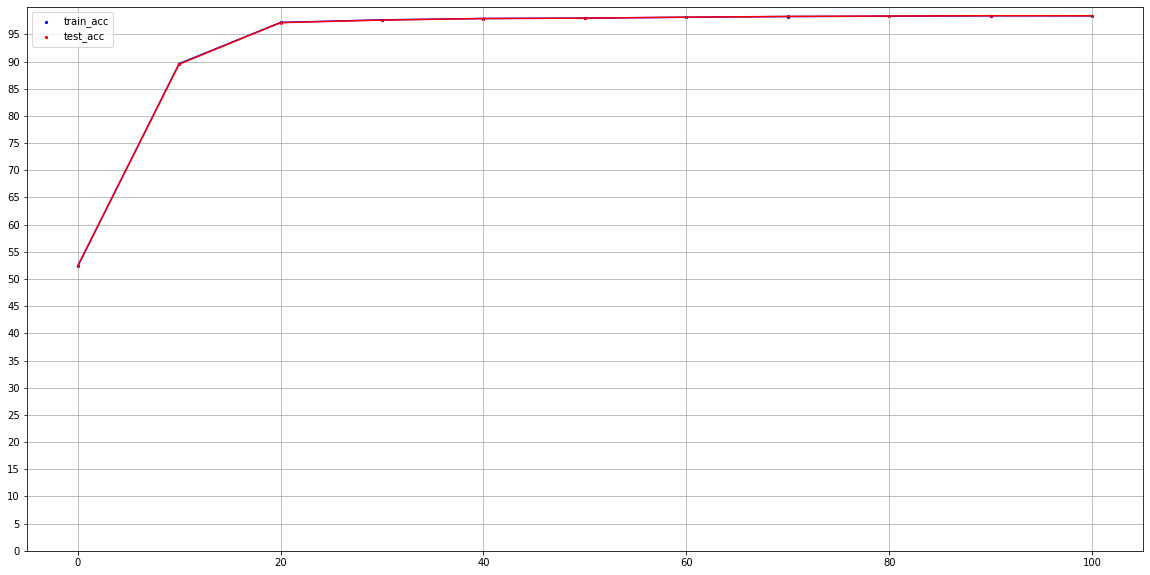

In [39]:
# Draw the learning curve
plt.figure(figsize=(20, 10))
plt.scatter(data=trace, x='epoch', y='train_acc', c="b", s=5)
plt.scatter(data=trace, x='epoch', y='test_acc', c="r", s=5)
plt.plot(trace['epoch'], trace['train_acc'], c="b")
plt.plot(trace['epoch'], trace['test_acc'], c="r")
plt.ylim((0, 100))
plt.yticks(np.arange(0, 100, 5))
plt.grid()
plt.legend()
plt.savefig("learning_curve.eps", format="eps", bbox_inches='tight')

# Loading the best weights and displaying the best model's performances
model.load_state_dict(best_model_weights)
stat_model(model, x_train, y_train, x_test, y_test)

In [41]:
torch.save(model.state_dict(), "./model.pytorch")
model.load_state_dict(torch.load("./model.pytorch"))

<All keys matched successfully>

In [42]:
adv_feat_stats = pd.DataFrame(index=df_training.columns[:-1])

adv_results = pd.DataFrame(index=['Accuracy', 
                                  'Mean perturbed features   [Mean L0]', 
                                  'Max perturbed features    [Max  L0]', 
                                  'Mean Euclidiant distance  [Mean L2]', 
                                  'Max Euclidiant distance   [Max  L2]', 
                                  'Mean Maximum perturbation [Mean Li]', 
                                  'Max Maximum perturbation  [Max  Li]'])

adv_inv = pd.DataFrame(index=['Invalid value range',
                              'Invalid binary values',
                              'Invalid class belonging'])

In [43]:
def adv_norms(x_test_cpu, adversarial_examples_cpu):
    mean_l0 = np.mean(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    max_l0 = np.max(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    mean_l2 = np.mean(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    max_l2 = np.max(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    mean_li = np.mean(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    max_li = np.max(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    return [mean_l0, max_l0, mean_l2, max_l2, mean_li, max_li]

In [44]:
df.shape

(820834, 79)

In [45]:
def adv_criteria(x_test_cpu, adversarial_examples_cpu):
    # Verify value ranges
    min = x_test_cpu.min(axis=1, keepdims=True)
    max = x_test_cpu.max(axis=1, keepdims=True)
    adv_range = (adversarial_examples_cpu < min) | (adversarial_examples_cpu > max)
    adv_range = adv_range.any(axis=1, keepdims=True)
    adv_range = adv_range.sum(axis=0)

    # Binary values
    binary_feat_ind = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 27, 29, 30, 31, 32, 33, 70, 72, 73, 74, 75, 76, 77]
    adv_bin = adversarial_examples_cpu[:, binary_feat_ind]
    adv_bin = (adv_bin != 1) & ( adv_bin != 0)
    adv_bin = adv_bin.any(axis=1, keepdims=True)
    adv_bin = adv_bin.sum(axis=0)

    # Multi class
    adv1 = adversarial_examples_cpu[:, 1:4] != 0
    adv1 = adv1.astype(int).sum(axis=1, keepdims=True) != 1
    adv1 = adv1.sum(axis=1, keepdims=True)

    adv2 = adversarial_examples_cpu[:, 4:74] != 0
    adv2 = adv2.astype(int).sum(axis=1, keepdims=True) != 1
    adv2 = adv2.sum(axis=1, keepdims=True)

    adv3 = adversarial_examples_cpu[:, 74:85] != 0
    adv3 = adv3.astype(int).sum(axis=1, keepdims=True) != 1
    adv3 = adv3.sum(axis=1, keepdims=True)

    adv_cat = adv1 | adv2 | adv3
    adv_cat = adv_cat.sum(axis=0)

    return [adv_range[0]*100/x_test.shape[0], adv_bin[0]*100/x_test.shape[0], adv_cat[0]*100/x_test.shape[0]]

In [46]:
positive_examples = df_testing[df_testing['class3'] == 1].values
x_test = torch.from_numpy((positive_examples[:, :-1])).float()
y_test = torch.from_numpy((positive_examples[:, -1])).float()
x_test = x_test.to(device)
y_test = y_test.to(device)

In [47]:
classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=input_size, nb_classes=output_size)

In [48]:
_, predictions_clean = model(x_test, softmax=True).max(dim=1)
accuracy_clean = evaluate(predictions=predictions_clean.long(), real=y_test)

attack='Clean'

# Exporting the clean positive examples in a .csv file
pd.DataFrame(np.hstack((x_test.cpu().numpy(),y_test.cpu().numpy().reshape(y_test.shape[0], 1))), columns=df.columns).to_csv("clean_examples.csv")

x_test_cpu = np.array(x_test.cpu())
adv_results[attack] = [accuracy_clean] + adv_norms(x_test_cpu, x_test_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, x_test_cpu)

print(adv_results[attack])
print(adv_inv[attack])

Accuracy                               97.03445
Mean perturbed features   [Mean L0]     0.00000
Max perturbed features    [Max  L0]     0.00000
Mean Euclidiant distance  [Mean L2]     0.00000
Max Euclidiant distance   [Max  L2]     0.00000
Mean Maximum perturbation [Mean Li]     0.00000
Max Maximum perturbation  [Max  Li]     0.00000
Name: Clean, dtype: float64
Invalid value range          0.0
Invalid binary values        0.0
Invalid class belonging    100.0
Name: Clean, dtype: float64


In [49]:
binary_cols = []
for col in df.columns:
    if df[col].dropna().isin([0, 1]).all():
        binary_cols.append(col)

# Get the index positions of the binary columns
binary_cols_index = [df.columns.get_loc(col) for col in binary_cols]

# Print the binary columns and their index positions
print("Binary columns: ", binary_cols)
print("Index positions of binary columns: ", binary_cols_index)

Binary columns:  ['Servicewebsocket', 'Servicessh', 'Servicesmtp', 'Servicesimple_service_discovery', 'Serviceprivate', 'Serviceother', 'Servicenetbios-ns', 'Servicemysql', 'Servicemqtt', 'Servicemodbus', 'Serviceimap', 'Servicehttps', 'Servicehttp', 'Serviceecho', 'Servicedns', 'Servicedhcp', 'Servicecoap', 'Protocoludp', 'Protocoltcp', 'Protocolicmp', 'Conn_state', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST', 'OSSEC_alert', 'Login_attempt', 'Succesful_login', 'File_activity', 'Process_activity', 'read_write_physical.process', 'is_privileged', 'class3']
Index positions of binary columns:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 27, 29, 30, 31, 32, 33, 70, 72, 73, 74, 75, 76, 77, 78]


In [50]:
binary_cols = []
for col in df.columns:
    if df[col].dropna().isin([0, 1]).all():
        binary_cols.append(col)

# Get the index positions of the binary columns
binary_cols_index = [df.columns.get_loc(col) for col in binary_cols]

# Print the binary columns and their index positions
print("Binary columns: ", binary_cols)
print("Index positions of binary columns: ", binary_cols_index)

Binary columns:  ['Servicewebsocket', 'Servicessh', 'Servicesmtp', 'Servicesimple_service_discovery', 'Serviceprivate', 'Serviceother', 'Servicenetbios-ns', 'Servicemysql', 'Servicemqtt', 'Servicemodbus', 'Serviceimap', 'Servicehttps', 'Servicehttp', 'Serviceecho', 'Servicedns', 'Servicedhcp', 'Servicecoap', 'Protocoludp', 'Protocoltcp', 'Protocolicmp', 'Conn_state', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST', 'OSSEC_alert', 'Login_attempt', 'Succesful_login', 'File_activity', 'Process_activity', 'read_write_physical.process', 'is_privileged', 'class3']
Index positions of binary columns:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 27, 29, 30, 31, 32, 33, 70, 72, 73, 74, 75, 76, 77, 78]


In [51]:
binary_cols_index = [df.columns.get_loc(col) for col in df.columns]


In [52]:
column_indices = {column_name: index for index, column_name in enumerate(df.columns)}
print(column_indices)


{'Scr_IP': 0, 'Servicewebsocket': 1, 'Servicessh': 2, 'Servicesmtp': 3, 'Servicesimple_service_discovery': 4, 'Serviceprivate': 5, 'Serviceother': 6, 'Servicenetbios-ns': 7, 'Servicemysql': 8, 'Servicemqtt': 9, 'Servicemodbus': 10, 'Serviceimap': 11, 'Servicehttps': 12, 'Servicehttp': 13, 'Serviceecho': 14, 'Servicedns': 15, 'Servicedhcp': 16, 'Servicecoap': 17, 'Protocoludp': 18, 'Protocoltcp': 19, 'Protocolicmp': 20, 'Scr_port': 21, 'Des_IP': 22, 'Des_port': 23, 'Duration': 24, 'Scr_bytes': 25, 'Des_bytes': 26, 'Conn_state': 27, 'missed_bytes': 28, 'is_syn_only': 29, 'Is_SYN_ACK': 30, 'is_pure_ack': 31, 'is_with_payload': 32, 'FIN or RST': 33, 'Scr_pkts': 34, 'Scr_ip_bytes': 35, 'Des_pkts': 36, 'Des_ip_bytes': 37, 'total_bytes': 38, 'total_packet': 39, 'paket_rate': 40, 'byte_rate': 41, 'Scr_packts_ratio': 42, 'Des_pkts_ratio': 43, 'Scr_bytes_ratio': 44, 'Des_bytes_ratio': 45, 'Avg_user_time': 46, 'Std_user_time': 47, 'Avg_nice_time': 48, 'Std_nice_time': 49, 'Avg_system_time': 50, '

In [54]:
import numpy as np
import torch
import pandas as pd

# Assuming 'x_test', 'model', 'classifier', and 'y_test' are already defined and loaded
# Assuming 'data' is a DataFrame containing your entire dataset (training + testing)

# Calculate min and max values for each feature from the entire dataset
feature_data = df.iloc[:, :-1]  # Adjust this to match your actual feature columns

feature_min = feature_data.min()
feature_max = feature_data.max()

# Create the adversarial examples crafter
adversarial_crafter = FastGradientMethod(
    classifier,
    norm=np.inf,
    eps=0.1,
    targeted=False,
    num_random_init=0,
    batch_size=128,
)

# Generate the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# Convert adversarial examples to torch tensors
adversarial_examples = torch.from_numpy(adversarial_examples).float()

# Ensure the perturbation for each feature stays within the observed min-max range
for i, (min_val, max_val) in enumerate(zip(feature_min, feature_max)):
    adversarial_examples[:, i] = torch.clamp(adversarial_examples[:, i], min=min_val, max=max_val)

adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Continue with the evaluation and processing
stat_model(model, x_test, y_test, adversarial_examples, y_test)

# Convert to CPU numpy arrays for further analysis
adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

# Evaluate the model on adversarial examples
_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'FGSM'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Export the adjusted adversarial examples to a CSV file
pd.DataFrame(np.hstack((adversarial_examples_cpu, y_test.cpu().reshape(y_test.shape[0], 1))), columns=df.columns).to_csv("adjusted_adversarial_examples_FGSM-IIoT.csv")

print(adv_results[attack])
print(adv_inv[attack])


Final Training Accuracy: 97.0344%
Final Testing Accuracy : 2.9656%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.03      0.06     79884

    accuracy                           0.03     79884
   macro avg       0.50      0.01      0.03     79884
weighted avg       1.00      0.03      0.06     79884



C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy                                2.965550
Mean perturbed features   [Mean L0]    65.388588
Max perturbed features    [Max  L0]    73.000000
Mean Euclidiant distance  [Mean L2]     0.559537
Max Euclidiant distance   [Max  L2]     0.664023
Mean Maximum perturbation [Mean Li]     0.100000
Max Maximum perturbation  [Max  Li]     0.100000
Name: FGSM, dtype: float64
Invalid value range          0.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: FGSM, dtype: float64


In [55]:
import pandas as pd

# Load the datasets
data_x1 = pd.read_csv('clean_examples.csv')  # Original dataset
data_x2 = pd.read_csv('adjusted_adversarial_examples_FGSM-IIoT.csv')  # Perturbed dataset
# List of columns to keep in x2
columns_to_keep =['Scr_IP','Scr_port', 'Des_IP', 'Des_port','Servicewebsocket', 'Servicessh', 'Servicesmtp', 'Servicesimple_service_discovery', 'Serviceprivate', 'Serviceother', 'Servicenetbios-ns', 'Servicemysql', 'Servicemqtt', 'Servicemodbus', 'Serviceimap', 'Servicehttps', 'Servicehttp', 'Serviceecho', 'Servicedns', 'Servicedhcp', 'Servicecoap', 'Protocoludp', 'Protocoltcp', 'Protocolicmp', 'Conn_state', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST', 'OSSEC_alert', 'Login_attempt', 'Succesful_login', 'File_activity', 'Process_activity', 'read_write_physical.process', 'is_privileged']

# Ensure column names are consistent and exist in both dataframes
columns_to_keep = [col for col in columns_to_keep if col in data_x2.columns and col in data_x1.columns]

# Columns to replace in x2 with values from x1 (all columns not in 'columns_to_keep')
columns_to_replace = [col for col in data_x2.columns if col not in columns_to_keep]

# Replace the values
data_x2[columns_to_replace] = data_x1[columns_to_replace]
# Save the modified x2 dataset
data_x2.to_csv('OFF_FGSM-IIoT.csv', index=False)


In [56]:
import numpy as np
import torch
import pandas as pd

# Assuming 'x_test', 'model', 'classifier', and 'y_test' are already defined and loaded
# Assuming 'data' is a DataFrame containing your entire dataset (training + testing)

# Calculate min and max values for each feature from the entire dataset
feature_data = df.iloc[:, :-1]  # Adjust this to match your actual feature columns

feature_min = feature_data.min()
feature_max = feature_data.max()

# Create the adversarial examples crafter
adversarial_crafter = BasicIterativeMethod(classifier, 
                                           eps=0.1, 
                                           eps_step=0.001,
                                           max_iter=100, 
                                           targeted=False, 
                                           batch_size=128)

# Generate the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# Convert adversarial examples to torch tensors
adversarial_examples = torch.from_numpy(adversarial_examples).float()

# Ensure the perturbation for each feature stays within the observed min-max range
for i, (min_val, max_val) in enumerate(zip(feature_min, feature_max)):
    adversarial_examples[:, i] = torch.clamp(adversarial_examples[:, i], min=min_val, max=max_val)

adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Continue with the evaluation and processing
stat_model(model, x_test, y_test, adversarial_examples, y_test)

# Convert to CPU numpy arrays for further analysis
adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

# Evaluate the model on adversarial examples
_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'BIM'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Export the adjusted adversarial examples to a CSV file
pd.DataFrame(np.hstack((adversarial_examples_cpu, y_test.cpu().reshape(y_test.shape[0], 1))), columns=df.columns).to_csv("adjusted_adversarial_examples_BIM-IIoT.csv")

print(adv_results[attack])
print(adv_inv[attack])


Final Training Accuracy: 97.0344%
Final Testing Accuracy : 2.9656%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.03      0.06     79884

    accuracy                           0.03     79884
   macro avg       0.50      0.01      0.03     79884
weighted avg       1.00      0.03      0.06     79884



C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy                                2.965550
Mean perturbed features   [Mean L0]    64.014271
Max perturbed features    [Max  L0]    71.000000
Mean Euclidiant distance  [Mean L2]     0.441642
Max Euclidiant distance   [Max  L2]     0.543281
Mean Maximum perturbation [Mean Li]     0.100000
Max Maximum perturbation  [Max  Li]     0.100000
Name: BIM, dtype: float64
Invalid value range          0.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: BIM, dtype: float64


In [57]:
import pandas as pd

# Load the datasets
data_x1 = pd.read_csv('clean_examples.csv')  # Original dataset
data_x2 = pd.read_csv('adjusted_adversarial_examples_BIM-IIoT.csv')  # Perturbed dataset
# List of columns to keep in x2
columns_to_keep =['Scr_IP','Scr_port', 'Des_IP', 'Des_port','Servicewebsocket', 'Servicessh', 'Servicesmtp', 'Servicesimple_service_discovery', 'Serviceprivate', 'Serviceother', 'Servicenetbios-ns', 'Servicemysql', 'Servicemqtt', 'Servicemodbus', 'Serviceimap', 'Servicehttps', 'Servicehttp', 'Serviceecho', 'Servicedns', 'Servicedhcp', 'Servicecoap', 'Protocoludp', 'Protocoltcp', 'Protocolicmp', 'Conn_state', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST', 'OSSEC_alert', 'Login_attempt', 'Succesful_login', 'File_activity', 'Process_activity', 'read_write_physical.process', 'is_privileged']

# Ensure column names are consistent and exist in both dataframes
columns_to_keep = [col for col in columns_to_keep if col in data_x2.columns and col in data_x1.columns]

# Columns to replace in x2 with values from x1 (all columns not in 'columns_to_keep')
columns_to_replace = [col for col in data_x2.columns if col not in columns_to_keep]

# Replace the values
data_x2[columns_to_replace] = data_x1[columns_to_replace]
# Save the modified x2 dataset
data_x2.to_csv('OFF_BIM.csv', index=False)


In [58]:
pwd

'C:\\adversarial_analysis-master\\Investigating_the_Practicality_of_Adversarial_Evasion_Attacks_on_Network_Intrusion_Detection\\XAAE-IIoT'

In [59]:
import numpy as np
import torch
import pandas as pd

# Assuming 'x_test', 'model', 'classifier', and 'y_test' are already defined and loaded
# Assuming 'data' is a DataFrame containing your entire dataset (training + testing)

# Calculate min and max values for each feature from the entire dataset
feature_data = df.iloc[:, :-1]  # Adjust this to match your actual feature columns

feature_min = feature_data.min()
feature_max = feature_data.max()

# Create the adversarial examples crafter
# Creating the adversarial examples crafter
adversarial_crafter = DeepFool(classifier, 
                               max_iter=100, 
                               epsilon=1e-6, 
                               nb_grads=10, 
                               batch_size=128)

# Generate the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# Convert adversarial examples to torch tensors
adversarial_examples = torch.from_numpy(adversarial_examples).float()

# Ensure the perturbation for each feature stays within the observed min-max range
for i, (min_val, max_val) in enumerate(zip(feature_min, feature_max)):
    adversarial_examples[:, i] = torch.clamp(adversarial_examples[:, i], min=min_val, max=max_val)

adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Continue with the evaluation and processing
stat_model(model, x_test, y_test, adversarial_examples, y_test)

# Convert to CPU numpy arrays for further analysis
adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

# Evaluate the model on adversarial examples
_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'DF'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Export the adjusted adversarial examples to a CSV file
pd.DataFrame(np.hstack((adversarial_examples_cpu, y_test.cpu().reshape(y_test.shape[0], 1))), columns=df.columns).to_csv("adjusted_adversarial_examples_DF-IIoT.csv")

print(adv_results[attack])
print(adv_inv[attack])


DeepFool: 100%|██████████████████████████████████████████████████████████████████████| 625/625 [00:25<00:00, 24.88it/s]


Final Training Accuracy: 97.0344%
Final Testing Accuracy : 74.9562%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86     79884

    accuracy                           0.75     79884
   macro avg       0.50      0.37      0.43     79884
weighted avg       1.00      0.75      0.86     79884



C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy                               74.956186
Mean perturbed features   [Mean L0]    65.386999
Max perturbed features    [Max  L0]    73.000000
Mean Euclidiant distance  [Mean L2]     0.034679
Max Euclidiant distance   [Max  L2]     0.183002
Mean Maximum perturbation [Mean Li]     0.077898
Max Maximum perturbation  [Max  Li]     0.202520
Name: DF, dtype: float64
Invalid value range          0.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: DF, dtype: float64


In [60]:
import pandas as pd

# Load the datasets
data_x1 = pd.read_csv('clean_examples.csv')  # Original dataset
data_x2 = pd.read_csv('adjusted_adversarial_examples_DF-IIoT.csv')  # Perturbed dataset
# List of columns to keep in x2
columns_to_keep =['Scr_IP','Scr_port', 'Des_IP', 'Des_port','Servicewebsocket', 'Servicessh', 'Servicesmtp', 'Servicesimple_service_discovery', 'Serviceprivate', 'Serviceother', 'Servicenetbios-ns', 'Servicemysql', 'Servicemqtt', 'Servicemodbus', 'Serviceimap', 'Servicehttps', 'Servicehttp', 'Serviceecho', 'Servicedns', 'Servicedhcp', 'Servicecoap', 'Protocoludp', 'Protocoltcp', 'Protocolicmp', 'Conn_state', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST', 'OSSEC_alert', 'Login_attempt', 'Succesful_login', 'File_activity', 'Process_activity', 'read_write_physical.process', 'is_privileged']

# Ensure column names are consistent and exist in both dataframes
columns_to_keep = [col for col in columns_to_keep if col in data_x2.columns and col in data_x1.columns]

# Columns to replace in x2 with values from x1 (all columns not in 'columns_to_keep')
columns_to_replace = [col for col in data_x2.columns if col not in columns_to_keep]

# Replace the values
data_x2[columns_to_replace] = data_x1[columns_to_replace]
# Save the modified x2 dataset
data_x2.to_csv('OFF_DF.csv', index=False)


In [61]:
import numpy as np
import torch
import pandas as pd

# Assuming 'x_test', 'model', 'classifier', and 'y_test' are already defined and loaded
# Assuming 'data' is a DataFrame containing your entire dataset (training + testing)

# Calculate min and max values for each feature from the entire dataset
feature_data = df.iloc[:, :-1]  # Adjust this to match your actual feature columns

feature_min = feature_data.min()
feature_max = feature_data.max()

# Create the adversarial examples crafter
# Creating the adversarial examples crafter
adversarial_crafter = SaliencyMapMethod(classifier,
                                        theta = 0.1,
                                        gamma = 1.0,
                                        batch_size=128)

# Generate the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# Convert adversarial examples to torch tensors
adversarial_examples = torch.from_numpy(adversarial_examples).float()

# Ensure the perturbation for each feature stays within the observed min-max range
for i, (min_val, max_val) in enumerate(zip(feature_min, feature_max)):
    adversarial_examples[:, i] = torch.clamp(adversarial_examples[:, i], min=min_val, max=max_val)

adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Continue with the evaluation and processing
stat_model(model, x_test, y_test, adversarial_examples, y_test)

# Convert to CPU numpy arrays for further analysis
adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

# Evaluate the model on adversarial examples
_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'JSMA'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Export the adjusted adversarial examples to a CSV file
pd.DataFrame(np.hstack((adversarial_examples_cpu, y_test.cpu().reshape(y_test.shape[0], 1))), columns=df.columns).to_csv("adjusted_adversarial_examples_JSMA-IIoT.csv")

print(adv_results[attack])
print(adv_inv[attack])


JSMA: 100%|██████████████████████████████████████████████████████████████████████████| 625/625 [00:12<00:00, 48.63it/s]


Final Training Accuracy: 97.0344%
Final Testing Accuracy : 2.9656%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.03      0.06     79884

    accuracy                           0.03     79884
   macro avg       0.50      0.01      0.03     79884
weighted avg       1.00      0.03      0.06     79884



C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy                               2.965550
Mean perturbed features   [Mean L0]    2.021857
Max perturbed features    [Max  L0]    4.000000
Mean Euclidiant distance  [Mean L2]    0.127167
Max Euclidiant distance   [Max  L2]    0.380000
Mean Maximum perturbation [Mean Li]    0.245579
Max Maximum perturbation  [Max  Li]    0.500000
Name: JSMA, dtype: float64
Invalid value range          0.000000
Invalid binary values        0.405588
Invalid class belonging    100.000000
Name: JSMA, dtype: float64


In [62]:
import pandas as pd

# Load the datasets
data_x1 = pd.read_csv('clean_examples.csv')  # Original dataset
data_x2 = pd.read_csv('adjusted_adversarial_examples_JSMA-IIoT.csv')  # Perturbed dataset
# List of columns to keep in x2
columns_to_keep =['Scr_IP','Scr_port', 'Des_IP', 'Des_port','Servicewebsocket', 'Servicessh', 'Servicesmtp', 'Servicesimple_service_discovery', 'Serviceprivate', 'Serviceother', 'Servicenetbios-ns', 'Servicemysql', 'Servicemqtt', 'Servicemodbus', 'Serviceimap', 'Servicehttps', 'Servicehttp', 'Serviceecho', 'Servicedns', 'Servicedhcp', 'Servicecoap', 'Protocoludp', 'Protocoltcp', 'Protocolicmp', 'Conn_state', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST', 'OSSEC_alert', 'Login_attempt', 'Succesful_login', 'File_activity', 'Process_activity', 'read_write_physical.process', 'is_privileged']

# Ensure column names are consistent and exist in both dataframes
columns_to_keep = [col for col in columns_to_keep if col in data_x2.columns and col in data_x1.columns]

# Columns to replace in x2 with values from x1 (all columns not in 'columns_to_keep')
columns_to_replace = [col for col in data_x2.columns if col not in columns_to_keep]

# Replace the values
data_x2[columns_to_replace] = data_x1[columns_to_replace]
# Save the modified x2 dataset
data_x2.to_csv('OFF_JSMA.csv', index=False)


In [63]:
import numpy as np
import torch
import pandas as pd

# Assuming 'x_test', 'model', 'classifier', and 'y_test' are already defined and loaded
# Assuming 'data' is a DataFrame containing your entire dataset (training + testing)

# Calculate min and max values for each feature from the entire dataset
feature_data = df.iloc[:, :-1]  # Adjust this to match your actual feature columns

feature_min = feature_data.min()
feature_max = feature_data.max()

# Create the adversarial examples crafter
# Creating the adversarial examples crafter
# Creating the adversarial examples crafter
adversarial_crafter = CarliniL2Method(classifier,
                                      confidence=0.0,
                                      targeted=False,
                                      learning_rate=0.01,
                                      binary_search_steps=10,
                                      max_iter=10,
                                      initial_const=0.01,
                                      max_halving=5,
                                      max_doubling=5,
                                      batch_size=128)

# Generate the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# Convert adversarial examples to torch tensors
adversarial_examples = torch.from_numpy(adversarial_examples).float()

# Ensure the perturbation for each feature stays within the observed min-max range
for i, (min_val, max_val) in enumerate(zip(feature_min, feature_max)):
    adversarial_examples[:, i] = torch.clamp(adversarial_examples[:, i], min=min_val, max=max_val)

adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Continue with the evaluation and processing
stat_model(model, x_test, y_test, adversarial_examples, y_test)

# Convert to CPU numpy arrays for further analysis
adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

# Evaluate the model on adversarial examples
_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'CW2'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Export the adjusted adversarial examples to a CSV file
pd.DataFrame(np.hstack((adversarial_examples_cpu, y_test.cpu().reshape(y_test.shape[0], 1))), columns=df.columns).to_csv("adjusted_adversarial_examples_CW2-IIoT.csv")

print(adv_results[attack])
print(adv_inv[attack])


C&W L_2: 100%|███████████████████████████████████████████████████████████████████████| 625/625 [21:47<00:00,  2.09s/it]


Final Training Accuracy: 97.0344%
Final Testing Accuracy : 3.2197%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.03      0.06     79884

    accuracy                           0.03     79884
   macro avg       0.50      0.02      0.03     79884
weighted avg       1.00      0.03      0.06     79884



C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy                                3.219669
Mean perturbed features   [Mean L0]    77.999987
Max perturbed features    [Max  L0]    78.000000
Mean Euclidiant distance  [Mean L2]     0.309571
Max Euclidiant distance   [Max  L2]     2.202955
Mean Maximum perturbation [Mean Li]     0.350274
Max Maximum perturbation  [Max  Li]     0.895667
Name: CW2, dtype: float64
Invalid value range          0.0
Invalid binary values      100.0
Invalid class belonging    100.0
Name: CW2, dtype: float64


In [64]:
import pandas as pd

# Load the datasets
data_x1 = pd.read_csv('clean_examples.csv')  # Original dataset
data_x2 = pd.read_csv('adjusted_adversarial_examples_CW2-IIoT.csv')  # Perturbed dataset
# List of columns to keep in x2
columns_to_keep =['Scr_IP','Scr_port', 'Des_IP', 'Des_port','Servicewebsocket', 'Servicessh', 'Servicesmtp', 'Servicesimple_service_discovery', 'Serviceprivate', 'Serviceother', 'Servicenetbios-ns', 'Servicemysql', 'Servicemqtt', 'Servicemodbus', 'Serviceimap', 'Servicehttps', 'Servicehttp', 'Serviceecho', 'Servicedns', 'Servicedhcp', 'Servicecoap', 'Protocoludp', 'Protocoltcp', 'Protocolicmp', 'Conn_state', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST', 'OSSEC_alert', 'Login_attempt', 'Succesful_login', 'File_activity', 'Process_activity', 'read_write_physical.process', 'is_privileged']

# Ensure column names are consistent and exist in both dataframes
columns_to_keep = [col for col in columns_to_keep if col in data_x2.columns and col in data_x1.columns]

# Columns to replace in x2 with values from x1 (all columns not in 'columns_to_keep')
columns_to_replace = [col for col in data_x2.columns if col not in columns_to_keep]

# Replace the values
data_x2[columns_to_replace] = data_x1[columns_to_replace]
# Save the modified x2 dataset
data_x2.to_csv('OFF_CW2.csv', index=False)


In [65]:
import numpy as np
import torch
import pandas as pd

# Assuming 'x_test', 'model', 'classifier', and 'y_test' are already defined and loaded
# Assuming 'data' is a DataFrame containing your entire dataset (training + testing)

# Calculate min and max values for each feature from the entire dataset
feature_data = df.iloc[:, :-1]  # Adjust this to match your actual feature columns

feature_min = feature_data.min()
feature_max = feature_data.max()

# Create the adversarial examples crafter
# Creating the adversarial examples crafter
# Creating the adversarial examples crafter
adversarial_crafter = CarliniLInfMethod(classifier,
                                        confidence=0.0,
                                        targeted=False,
                                        learning_rate=0.01,
                                        max_iter=10,
                                        max_halving=5,
                                        max_doubling=5,
                                        eps=0.1,
                                        batch_size=128)

# Generate the adversarial examples
adversarial_examples = adversarial_crafter.generate(x=x_test.cpu())

# Convert adversarial examples to torch tensors
adversarial_examples = torch.from_numpy(adversarial_examples).float()

# Ensure the perturbation for each feature stays within the observed min-max range
for i, (min_val, max_val) in enumerate(zip(feature_min, feature_max)):
    adversarial_examples[:, i] = torch.clamp(adversarial_examples[:, i], min=min_val, max=max_val)

adversarial_examples = adversarial_examples.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Continue with the evaluation and processing
stat_model(model, x_test, y_test, adversarial_examples, y_test)

# Convert to CPU numpy arrays for further analysis
adversarial_examples_cpu = np.array(adversarial_examples.cpu())
x_test_cpu = np.array(x_test.cpu())

# Evaluate the model on adversarial examples
_, predictions_adv = model(adversarial_examples, softmax=True).max(dim=1)
accuracy_adv = evaluate(predictions=predictions_adv.long(), real=y_test)
attack = 'CWinf'
adv_results[attack] = [accuracy_adv] + adv_norms(x_test_cpu, adversarial_examples_cpu)
adv_inv[attack] = adv_criteria(x_test_cpu, adversarial_examples_cpu)

# Export the adjusted adversarial examples to a CSV file
pd.DataFrame(np.hstack((adversarial_examples_cpu, y_test.cpu().reshape(y_test.shape[0], 1))), columns=df.columns).to_csv("adjusted_adversarial_examples_CWinf-IIoT.csv")

print(adv_results[attack])
print(adv_inv[attack])


C&W L_inf: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [01:45<00:00,  5.95it/s]


Final Training Accuracy: 97.0344%
Final Testing Accuracy : 3.1646%
Classification Report :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.03      0.06     79884

    accuracy                           0.03     79884
   macro avg       0.50      0.02      0.03     79884
weighted avg       1.00      0.03      0.06     79884



C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy                                3.164589
Mean perturbed features   [Mean L0]    77.694632
Max perturbed features    [Max  L0]    78.000000
Mean Euclidiant distance  [Mean L2]     0.226900
Max Euclidiant distance   [Max  L2]     0.496392
Mean Maximum perturbation [Mean Li]     0.098768
Max Maximum perturbation  [Max  Li]     0.100000
Name: CWinf, dtype: float64
Invalid value range          0.000000
Invalid binary values       99.788443
Invalid class belonging    100.000000
Name: CWinf, dtype: float64


In [66]:
import pandas as pd

# Load the datasets
data_x1 = pd.read_csv('clean_examples.csv')  # Original dataset
data_x2 = pd.read_csv('adjusted_adversarial_examples_CWinf-IIoT.csv')  # Perturbed dataset
# List of columns to keep in x2
columns_to_keep =['Scr_IP','Scr_port', 'Des_IP', 'Des_port','Servicewebsocket', 'Servicessh', 'Servicesmtp', 'Servicesimple_service_discovery', 'Serviceprivate', 'Serviceother', 'Servicenetbios-ns', 'Servicemysql', 'Servicemqtt', 'Servicemodbus', 'Serviceimap', 'Servicehttps', 'Servicehttp', 'Serviceecho', 'Servicedns', 'Servicedhcp', 'Servicecoap', 'Protocoludp', 'Protocoltcp', 'Protocolicmp', 'Conn_state', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack', 'is_with_payload', 'FIN or RST', 'OSSEC_alert', 'Login_attempt', 'Succesful_login', 'File_activity', 'Process_activity', 'read_write_physical.process', 'is_privileged']

# Ensure column names are consistent and exist in both dataframes
columns_to_keep = [col for col in columns_to_keep if col in data_x2.columns and col in data_x1.columns]

# Columns to replace in x2 with values from x1 (all columns not in 'columns_to_keep')
columns_to_replace = [col for col in data_x2.columns if col not in columns_to_keep]

# Replace the values
data_x2[columns_to_replace] = data_x1[columns_to_replace]
# Save the modified x2 dataset
data_x2.to_csv('OFF_CWinf.csv', index=False)


In [68]:
df_training.to_csv('df_training.csv', index=False)

In [69]:
df_testing.to_csv('df_testing.csv', index=False)